# Problem I: Inverse Modeling with Neural Networks

## Learning Objectives

In this notebook, we explore a fundamental challenge in physics-informed machine learning: **inverse modeling**. Given observed data from a physical system, can we recover the underlying parameters that generated it?

We will:
1. Generate synthetic data from a known physical model (correlator function)
2. **Try I**: Attempt to recover parameters using a standard neural network approach
3. **Try II**: Learn from our mistakes and design a physics-informed architecture
4. Analyze why certain architectural choices succeed or fail

**Key Takeaway**: Low training loss does not guarantee correct parameter recovery. The network architecture must respect the physical/mathematical structure of the problem.

## 1. The Physical Model

We consider a correlator function inspired by lattice QCD, modeled as a sum of exponentially decaying terms:

$$
C(x) = \sum_{i=1}^{15} A_i \cdot x^2 \cdot e^{-c_i \cdot x}
$$

where:
- $x \in [0, 50]$ represents Euclidean time separations
- $A_i \in [0.5, 4.0]$ are **fixed** amplitudes (15 values)
- $c_i \in [0.01, 10]$ are **fixed** positive decay constants (15 values)

**The Inverse Problem**: Given measurements of $C(x)$ at various points, can we recover the true values of $\{A_i\}$ and $\{c_i\}$?

This is challenging because:
- We have 30 unknown parameters
- The function is nonlinear in the parameters
- Multiple parameter combinations might produce similar $C(x)$ values

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 1.1 Ground Truth Parameters

We randomly generate the "true" parameters that we will attempt to recover. These are the values our neural network should ideally learn.

In [2]:
# Number of exponential terms
n_terms = 15

# Ground truth parameters - THESE ARE WHAT WE WANT TO RECOVER
A_true = np.random.uniform(0.5, 4.0, size=n_terms)
c_true = np.random.uniform(0.01, 10.0, size=n_terms)

print("="*60)
print("GROUND TRUTH PARAMETERS (to be recovered)")
print("="*60)
print(f"\nAmplitudes A_i:\n{np.round(A_true, 4)}")
print()
print(f"Decay constants c_i:\n{np.round(c_true, 4)}")
print()
print(f"\nA range:\n[{A_true.min():.3f}, {A_true.max():.3f}]")
print()
print(f"c range:\n[{c_true.min():.4f}, {c_true.max():.4f}]")

GROUND TRUTH PARAMETERS (to be recovered)

Amplitudes A_i:
[1.8109 3.8275 3.062  2.5953 1.0461 1.046  0.7033 3.5316 2.6039 2.9783
 0.572  3.8947 3.4135 1.2432 1.1364]

Decay constants c_i:
[1.8422 3.0494 5.2523 4.3251 2.9194 6.1224 1.4035 2.9285 3.67   4.5661
 7.8539 2.0047 5.1472 5.9282 0.474 ]


A range:
[0.572, 3.895]

c range:
[0.4740, 7.8539]


In [3]:
def correlator(x, A, c):
    """Compute the correlator C(x) = Σ A_i · x^2 · exp(-c_i · x)"""
    result = np.zeros_like(x, dtype=np.float64)
    for A_i, c_i in zip(A, c):
        result += A_i * x**2 * np.exp(-c_i * x )
    return result

### 1.2 Data Generation

We generate 200 data points and apply **normalization**.

In [4]:
# Generate input values
x_data = np.random.uniform(0, 50, 200)
y_data = correlator(x_data, A_true, c_true)

print(f"x (unchanged): [{x_data.min():.2e}, {x_data.max():.2e}]")
print(f"y (unchanged): [{y_data.min():.2e}, {y_data.max():.2e}]")

x (unchanged): [2.53e-01, 4.93e+01]
y (unchanged): [1.92e-07, 2.81e+00]


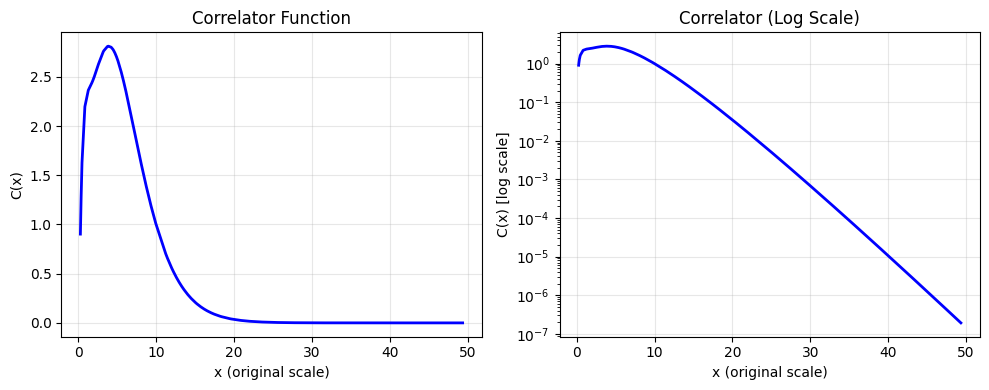

In [5]:
# Visualize the correlator
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(np.sort(x_data), correlator(np.sort(x_data), A_true, c_true), 'b-', linewidth=2)
plt.xlabel('x (original scale)')
plt.ylabel('C(x)')
plt.title('Correlator Function')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(np.sort(x_data), correlator(np.sort(x_data), A_true, c_true) + 1e-10, 'b-', linewidth=2)  # +1e-10 to avoid log(0)
plt.xlabel('x (original scale)')
plt.ylabel('C(x) [log scale]')
plt.title('Correlator (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3 PyTorch Dataset and DataLoaders

In [6]:
class CorrelatorDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1) # Make the shape (N, 1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Make the shape (N, 1)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset
dataset = CorrelatorDataset(x_data, y_data)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: { len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 160
Validation samples: 40



## 2. Try I: Neural Network Predicting Parameters from x

### The Idea

Our first attempt uses a standard approach: train a neural network $f_\theta$ that takes $x$ as input and outputs the 30 parameters $(A_1, ..., A_{15}, c_1, ..., c_{15})$.

$$f_\theta: x \mapsto (\hat{A}_1(x), ..., \hat{A}_{15}(x), \hat{c}_1(x), ..., \hat{c}_{15}(x))$$

Then we compute:
$$\hat{C}(x) = \sum_{i=1}^{15} \hat{A}_i(x) \cdot x^2 \cdot e^{-\hat{c}_i(x) \cdot x}$$

and minimize $\|\hat{C}(x) - C(x)\|^2$.

**Question to think about**: Do you see a potential problem with this formulation?

In [7]:
class CorrelatorInverseNet(nn.Module):
    """
    Try I: Neural network that predicts parameters from input x.
    
    Architecture: x → [Linear → SiLU] × 3 → Linear → (A, c)
    Then computes: Ĉ(x) = Σ A_i(x) · x² · exp(-c_i(x) · x)
    """
    
    def __init__(self, n_terms=15, hidden_dims=[64, 128, 64]):
        super().__init__()
        self.n_terms = n_terms
        
        # Feature extraction layers
        self.layers = nn.Sequential(
            nn.Linear(1, hidden_dims[0]),
            nn.SiLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.SiLU(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.SiLU(),
        )
        
        # Output: 2 * n_terms parameters (A_i and c_i)
        self.output_layer = nn.Linear(hidden_dims[-1], 2 * n_terms)
        self.softplus = nn.Softplus()
        
        # Store last predictions for analysis
        self.last_A = None
        self.last_c = None
    
    def forward(self, x):
        # Extract features and predict parameters
        features = self.layers(x)
        params = self.output_layer(features)
        
        # Split into A and c
        A = self.softplus(params[:, :self.n_terms])  # Ensure A > 0
        c = self.softplus(params[:, self.n_terms:])  # Ensure c > 0
        
        # Store for analysis
        if self.training:
            self.last_A = A.mean(dim=0).detach()
            self.last_c = c.mean(dim=0).detach()
        
        # Compute correlator: C(x) = sum( A_i · x^2 . exp(-c_i · x) )
        x_sq = x ** 2
        exp_term = torch.exp(-c * x)
        C_pred = torch.sum(A * x_sq * exp_term, dim=1, keepdim=True)
        return C_pred
    def get_parameters(self):
        return {'A': self.last_A, 'c': self.last_c}

In [8]:
# Initialize model
model_i = CorrelatorInverseNet(n_terms=15)
n_params = sum(p.numel() for p in model_i.parameters())

print(f"Try I Model Architecture:\n")
print(model_i)
print(f"\nTotal trainable parameters: {n_params:,}")

Try I Model Architecture:

CorrelatorInverseNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): SiLU()
  )
  (output_layer): Linear(in_features=64, out_features=30, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

Total trainable parameters: 18,654


In [9]:
# Training setup
optimizer_i = optim.Adam(model_i.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs_i = 100

train_losses_i = []
val_losses_i = []

print("Training Try I...")
for epoch in range(epochs_i):
    # Training
    model_i.train()
    epoch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer_i.zero_grad()
        y_pred = model_i(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer_i.step()
        epoch_train_loss += loss.item()
    train_losses_i.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model_i.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model_i(x_batch)
            loss = criterion(y_pred, y_batch)
            epoch_val_loss += loss.item()
    val_losses_i.append(epoch_val_loss / len(val_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_losses_i[-1]:.2e} | Val Loss: {val_losses_i[-1]:.2e}")

print("\nTraining complete!")

Training Try I...
Epoch   10 | Train Loss: 4.95e-01 | Val Loss: 3.37e-01
Epoch   20 | Train Loss: 1.55e-01 | Val Loss: 1.09e-01
Epoch   30 | Train Loss: 5.10e-02 | Val Loss: 4.09e-02
Epoch   40 | Train Loss: 1.48e-02 | Val Loss: 1.41e-02
Epoch   50 | Train Loss: 8.82e-03 | Val Loss: 8.80e-03
Epoch   60 | Train Loss: 6.90e-03 | Val Loss: 6.60e-03
Epoch   70 | Train Loss: 5.46e-03 | Val Loss: 4.83e-03
Epoch   80 | Train Loss: 4.25e-03 | Val Loss: 3.30e-03
Epoch   90 | Train Loss: 3.20e-03 | Val Loss: 2.04e-03
Epoch  100 | Train Loss: 2.34e-03 | Val Loss: 1.18e-03

Training complete!


In [10]:
# Analyze Try I results
params_i = model_i.get_parameters()
A_pred_i = params_i['A'].numpy()
c_pred_i = params_i['c'].numpy()

print("="*60)
print("TRY I: PARAMETER COMPARISON")
print("="*60)

print("\n--- Amplitudes A ---")
print(f"True:\n{np.round(A_true, 3)}")
print(f"Predicted:\n{np.round(A_pred_i, 3)}")

print("\n--- Decay Constants c ---")
print(f"True:\n{np.round(c_true, 4)}")
print(f"Predicted:\n{np.round(c_pred_i, 4)}")

# Quantify the error
A_rel_error = np.mean(np.abs(A_pred_i - A_true) / A_true) * 100
c_rel_error = np.mean(np.abs(c_pred_i - c_true) / c_true) * 100

print(f"\nMean Relative Error in A: {A_rel_error:.1f}%")
print(f"Mean Relative Error in c: {c_rel_error:.1f}%")

TRY I: PARAMETER COMPARISON

--- Amplitudes A ---
True:
[1.811 3.828 3.062 2.595 1.046 1.046 0.703 3.532 2.604 2.978 0.572 3.895
 3.414 1.243 1.136]
Predicted:
[0.105 0.354 0.5   0.173 0.236 0.141 0.344 1.461 0.126 0.24  0.306 0.138
 0.167 0.267 0.561]

--- Decay Constants c ---
True:
[1.8422 3.0494 5.2523 4.3251 2.9194 6.1224 1.4035 2.9285 3.67   4.5661
 7.8539 2.0047 5.1472 5.9282 0.474 ]
Predicted:
[2.5386 0.3662 3.0297 2.191  2.3844 2.2839 0.5202 0.6203 1.3703 2.901
 0.5119 2.3541 1.5513 0.6534 0.4496]

Mean Relative Error in A: 79.3%
Mean Relative Error in c: 54.3%


### Try I: Analysis and Conclusion

**Observation**: Despite achieving low training and validation loss, Try I **fails to recover the true parameters**.

**Why?** The fundamental issue is architectural:

1. **x-dependent parameters**: The network learns $A(x)$ and $c(x)$ - different parameter values for each input!

2. **Non-identifiability**: For any single point $x_0$, infinitely many $(A, c)$ combinations can produce the same $C(x_0)$. The network exploits this freedom.

3. **Physical inconsistency**: The true parameters are **constants**, but our network treats them as functions of $x$.

**Key Lesson**: Low reconstruction loss $\neq$ correct parameter recovery!

---
## 3. Try II: Global Learnable Parameters

### The Fix

The problem with Try I was that parameters varied with $x$. The solution is simple but profound:

**Make $A$ and $c$ direct learnable tensors (`nn.Parameter`), not network outputs.**

$$\hat{C}(x) = \sum_{i=1}^{15} A_i \cdot x^2 \cdot e^{-c_i \cdot x}$$

where $A$ and $c$ are **the same for all** $x$ values.

| Aspect | Try I | Try II |
|--------|-------|--------|
| Parameters | $A(x), c(x)$ from network | $A, c$ as `nn.Parameter` |
| Parameter count | 18,654 | 30 |
| Physical consistency | ❌ | lets check :) |

In [11]:
class GlobalParameterCorrelator(nn.Module):
    """
    Try II: Direct optimization of global parameters.
    Key insight: A and c are nn.Parameter tensors, NOT network outputs.
    The same values are used for ALL inputs x.
    """
    
    def __init__(self, n_terms=15):
        super().__init__()
        self.n_terms = n_terms
        
        # GLOBAL learnable parameters (not functions of x!)
        # Initialize near the middle of expected ranges
        self.A_raw = nn.Parameter(torch.zeros(n_terms))  # Will apply softplus
        self.c_raw = nn.Parameter(torch.zeros(n_terms))  # Will apply softplus
        
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        # Apply softplus to ensure positivity
        A = self.softplus(self.A_raw)
        c = self.softplus(self.c_raw)
        
        # Compute correlator (same A, c for all x in batch!)
        x_sq = x ** 2
        exp_term = torch.exp(-c * x)  # Broadcasting: (batch, 1) * (n_terms,)
        C_pred = torch.sum(A * x_sq * exp_term, dim=1, keepdim=True)
        return C_pred
    
    def get_parameters(self):
        with torch.no_grad():
            A = self.softplus(self.A_raw)
            c = self.softplus(self.c_raw)
        return {'A': A.numpy(), 'c': c.numpy()}

In [12]:
# Initialize model
model_ii = GlobalParameterCorrelator(n_terms=15)
n_params_ii = sum(p.numel() for p in model_ii.parameters())

print(f"Try II Model:")
print(model_ii)
print(f"\nTotal learnable parameters: {n_params_ii}")
print(f"(Compare to Try I: 18,654 parameters)")

Try II Model:
GlobalParameterCorrelator(
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

Total learnable parameters: 30
(Compare to Try I: 18,654 parameters)


In [13]:
# Training setup - higher learning rate since fewer parameters
optimizer_ii = optim.Adam(model_ii.parameters(), lr=1e-2)
epochs_ii = 1000  # More epochs for convergence

train_losses_ii = []
val_losses_ii = []

print("Training Try II...")
for epoch in range(epochs_ii):
    # Training
    model_ii.train()
    epoch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer_ii.zero_grad()
        y_pred = model_ii(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer_ii.step()
        epoch_train_loss += loss.item()
    train_losses_ii.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model_ii.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model_ii(x_batch)
            loss = criterion(y_pred, y_batch)
            epoch_val_loss += loss.item()
    val_losses_ii.append(epoch_val_loss / len(val_loader))
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_losses_ii[-1]:.2e} | Val Loss: {val_losses_ii[-1]:.2e}")

print("\nTraining complete!")

Training Try II...
Epoch   50 | Train Loss: 3.20e-01 | Val Loss: 2.44e-01
Epoch  100 | Train Loss: 2.41e-01 | Val Loss: 2.00e-01
Epoch  150 | Train Loss: 1.67e-01 | Val Loss: 1.48e-01
Epoch  200 | Train Loss: 1.13e-01 | Val Loss: 1.01e-01
Epoch  250 | Train Loss: 7.97e-02 | Val Loss: 6.84e-02
Epoch  300 | Train Loss: 6.25e-02 | Val Loss: 4.96e-02
Epoch  350 | Train Loss: 5.53e-02 | Val Loss: 4.06e-02
Epoch  400 | Train Loss: 5.27e-02 | Val Loss: 3.68e-02
Epoch  450 | Train Loss: 5.20e-02 | Val Loss: 3.54e-02
Epoch  500 | Train Loss: 5.19e-02 | Val Loss: 3.49e-02
Epoch  550 | Train Loss: 5.18e-02 | Val Loss: 3.47e-02
Epoch  600 | Train Loss: 5.20e-02 | Val Loss: 3.46e-02
Epoch  650 | Train Loss: 5.18e-02 | Val Loss: 3.45e-02
Epoch  700 | Train Loss: 5.19e-02 | Val Loss: 3.44e-02
Epoch  750 | Train Loss: 5.19e-02 | Val Loss: 3.48e-02
Epoch  800 | Train Loss: 5.14e-02 | Val Loss: 3.42e-02
Epoch  850 | Train Loss: 4.73e-02 | Val Loss: 3.17e-02
Epoch  900 | Train Loss: 4.10e-02 | Val Loss: 

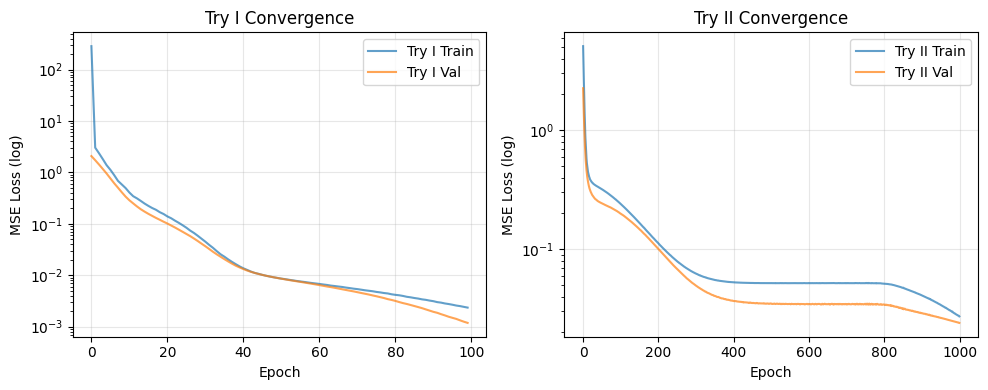

In [14]:
# Plot convergence comparison
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.semilogy(train_losses_i, label='Try I Train', alpha=0.7)
plt.semilogy(val_losses_i, label='Try I Val', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log)')
plt.title('Try I Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(train_losses_ii, label='Try II Train', alpha=0.7)
plt.semilogy(val_losses_ii, label='Try II Val', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log)')
plt.title('Try II Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Parameter Recovery Analysis

Now let's properly compare the learned parameters with the ground truth for both approaches.

In [15]:
# Get Try II parameters
params_ii = model_ii.get_parameters()
A_pred_ii = params_ii['A']
c_pred_ii = params_ii['c']

print("="*70)
print("PARAMETER RECOVERY COMPARISON")
print("="*70)

PARAMETER RECOVERY COMPARISON


In [16]:
# Compare Amplitudes A
print("\n" + "="*70)
print("AMPLITUDES (A) COMPARISON")
print("="*70)

# Sort for better comparison (parameters may be learned in different order)
A_true_sorted = np.sort(A_true)
A_pred_i_sorted = np.sort(A_pred_i)
A_pred_ii_sorted = np.sort(A_pred_ii)

print(f"\n{'i':<4} {'A_true':<10} {'A_Try_I':<10} {'Err_I %':<10} {'A_Try_II':<10} {'Err_II %':<10}")
print("-"*60)

for i in range(n_terms):
    err_i = abs(A_pred_i_sorted[i] - A_true_sorted[i]) / A_true_sorted[i] * 100
    err_ii = abs(A_pred_ii_sorted[i] - A_true_sorted[i]) / A_true_sorted[i] * 100
    print(f"{i:<4} {A_true_sorted[i]:<10.4f} {A_pred_i_sorted[i]:<10.4f} {err_i:<10.1f} {A_pred_ii_sorted[i]:<10.4f} {err_ii:<10.1f}")

mean_err_A_i = np.mean(np.abs(A_pred_i_sorted - A_true_sorted) / A_true_sorted) * 100
mean_err_A_ii = np.mean(np.abs(A_pred_ii_sorted - A_true_sorted) / A_true_sorted) * 100
print(f"\nMean Relative Error - Try I:  {mean_err_A_i:.1f}%")
print(f"Mean Relative Error - Try II: {mean_err_A_ii:.1f}%")


AMPLITUDES (A) COMPARISON

i    A_true     A_Try_I    Err_I %    A_Try_II   Err_II %  
------------------------------------------------------------
0    0.5720     0.1048     81.7       0.1084     81.0      
1    0.7033     0.1264     82.0       0.1084     84.6      
2    1.0460     0.1381     86.8       0.1084     89.6      
3    1.0461     0.1412     86.5       0.1084     89.6      
4    1.1364     0.1667     85.3       0.1084     90.5      
5    1.2432     0.1734     86.1       0.1084     91.3      
6    1.8109     0.2359     87.0       0.1084     94.0      
7    2.5953     0.2400     90.8       0.1084     95.8      
8    2.6039     0.2666     89.8       0.3042     88.3      
9    2.9783     0.3060     89.7       0.3042     89.8      
10   3.0620     0.3442     88.8       0.3042     90.1      
11   3.4135     0.3537     89.6       0.3042     91.1      
12   3.5316     0.5003     85.8       0.3042     91.4      
13   3.8275     0.5613     85.3       0.3042     92.1      
14   3.8947

In [17]:
# Compare Decay Constants c
print("\n" + "="*70)
print("DECAY CONSTANTS (c) COMPARISON")
print("="*70)

c_true_sorted = np.sort(c_true)
c_pred_i_sorted = np.sort(c_pred_i)
c_pred_ii_sorted = np.sort(c_pred_ii)

print(f"\n{'i':<4} {'c_true':<10} {'c_Try_I':<10} {'Err_I %':<10} {'c_Try_II':<10} {'Err_II %':<10}")
print("-"*60)

for i in range(n_terms):
    err_i = abs(c_pred_i_sorted[i] - c_true_sorted[i]) / c_true_sorted[i] * 100
    err_ii = abs(c_pred_ii_sorted[i] - c_true_sorted[i]) / c_true_sorted[i] * 100
    print(f"{i:<4} {c_true_sorted[i]:<10.5f} {c_pred_i_sorted[i]:<10.5f} {err_i:<10.1f} {c_pred_ii_sorted[i]:<10.5f} {err_ii:<10.1f}")

mean_err_c_i = np.mean(np.abs(c_pred_i_sorted - c_true_sorted) / c_true_sorted) * 100
mean_err_c_ii = np.mean(np.abs(c_pred_ii_sorted - c_true_sorted) / c_true_sorted) * 100
print(f"\nMean Relative Error - Try I:  {mean_err_c_i:.1f}%")
print(f"Mean Relative Error - Try II: {mean_err_c_ii:.1f}%")


DECAY CONSTANTS (c) COMPARISON

i    c_true     c_Try_I    Err_I %    c_Try_II   Err_II %  
------------------------------------------------------------
0    0.47404    0.36625    22.7       0.44910    5.3       
1    1.40354    0.44962    68.0       0.44910    68.0      
2    1.84221    0.51189    72.2       0.44910    75.6      
3    2.00474    0.52021    74.1       0.44910    77.6      
4    2.91938    0.62029    78.8       0.44910    84.6      
5    2.92853    0.65335    77.7       0.44910    84.7      
6    3.04938    1.37031    55.1       0.44910    85.3      
7    3.66995    1.55134    57.7       0.44910    87.8      
8    4.32513    2.19104    49.3       0.99145    77.1      
9    4.56614    2.28394    50.0       0.99145    78.3      
10   5.14720    2.35410    54.3       0.99145    80.7      
11   5.25232    2.38441    54.6       0.99145    81.1      
12   5.92822    2.53862    57.2       0.99145    83.3      
13   6.12241    2.90104    52.6       0.99145    83.8      
14   7

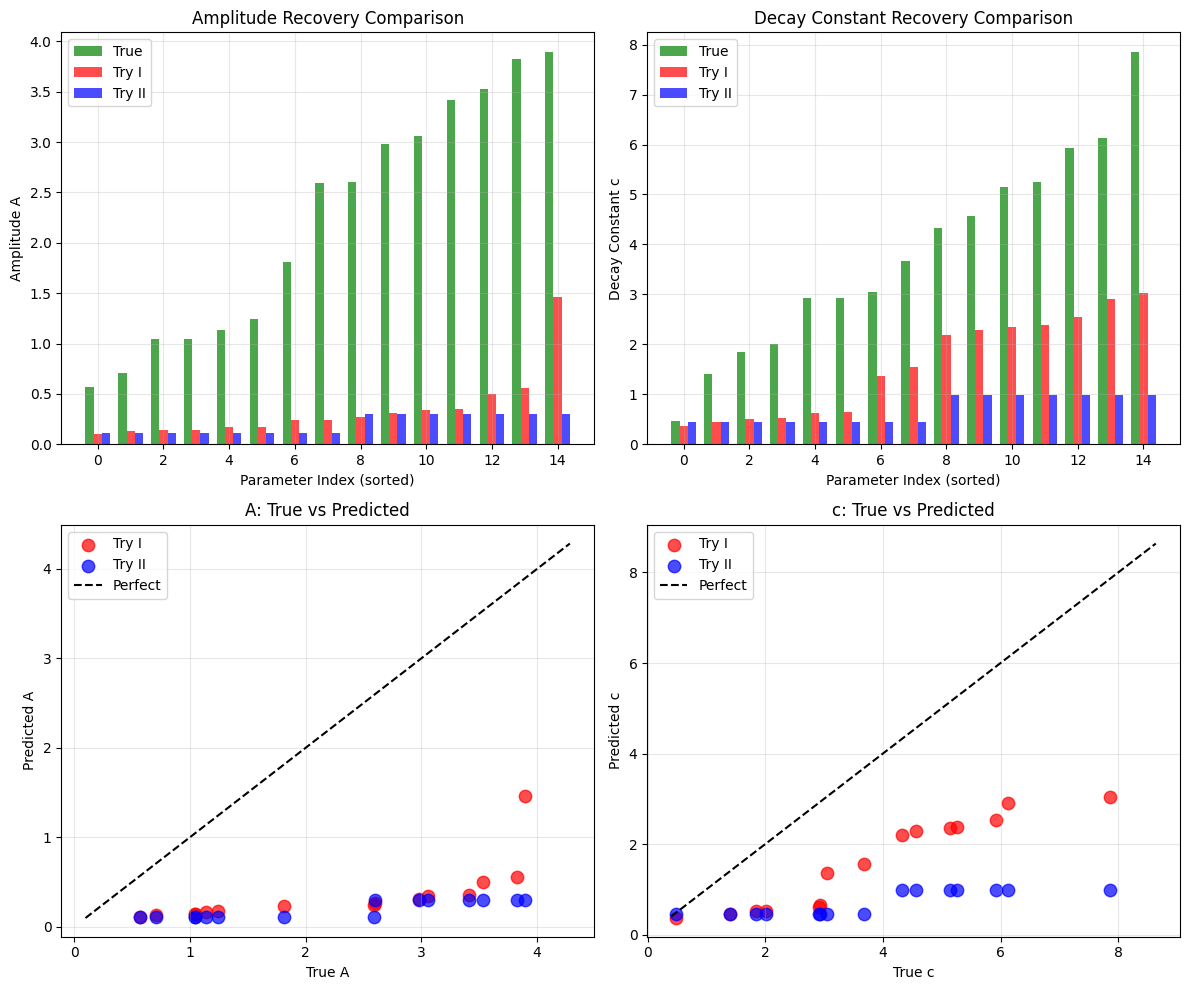

In [18]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# A comparison
ax = axes[0, 0]
x_idx = np.arange(n_terms)
width = 0.25
ax.bar(x_idx - width, A_true_sorted, width, label='True', color='green', alpha=0.7)
ax.bar(x_idx, A_pred_i_sorted, width, label='Try I', color='red', alpha=0.7)
ax.bar(x_idx + width, A_pred_ii_sorted, width, label='Try II', color='blue', alpha=0.7)
ax.set_xlabel('Parameter Index (sorted)')
ax.set_ylabel('Amplitude A')
ax.set_title('Amplitude Recovery Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# c comparison
ax = axes[0, 1]
ax.bar(x_idx - width, c_true_sorted, width, label='True', color='green', alpha=0.7)
ax.bar(x_idx, c_pred_i_sorted, width, label='Try I', color='red', alpha=0.7)
ax.bar(x_idx + width, c_pred_ii_sorted, width, label='Try II', color='blue', alpha=0.7)
ax.set_xlabel('Parameter Index (sorted)')
ax.set_ylabel('Decay Constant c')
ax.set_title('Decay Constant Recovery Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter: True vs Predicted (A)
ax = axes[1, 0]
ax.scatter(A_true_sorted, A_pred_i_sorted, label='Try I', color='red', alpha=0.7, s=80)
ax.scatter(A_true_sorted, A_pred_ii_sorted, label='Try II', color='blue', alpha=0.7, s=80)
lims = [min(A_true.min(), A_pred_ii.min()) * 0.9, max(A_true.max(), A_pred_ii.max()) * 1.1]
ax.plot(lims, lims, 'k--', label='Perfect')
ax.set_xlabel('True A')
ax.set_ylabel('Predicted A')
ax.set_title('A: True vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter: True vs Predicted (c)
ax = axes[1, 1]
ax.scatter(c_true_sorted, c_pred_i_sorted, label='Try I', color='red', alpha=0.7, s=80)
ax.scatter(c_true_sorted, c_pred_ii_sorted, label='Try II', color='blue', alpha=0.7, s=80)
lims = [min(c_true.min(), c_pred_ii.min()) * 0.9, max(c_true.max(), c_pred_ii.max()) * 1.1]
ax.plot(lims, lims, 'k--', label='Perfect')
ax.set_xlabel('True c')
ax.set_ylabel('Predicted c')
ax.set_title('c: True vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. Discussion: Why Does Try II Still Have Deviations?

You may notice that even Try II doesn't perfectly recover all parameters. This is due to several factors:

### 5.1 Parameter Degeneracy

With 15 exponential terms, some parameter combinations produce nearly identical functions. For example:
- Two terms with similar $c_i$ values can partially compensate each other
- The sum of 15 terms has inherent redundancy

### 5.2 Optimization Landscape

The loss function has multiple local minima. Different initializations may converge to different solutions that all fit the data well.

### 5.3 Finite Data

With 200 data points and 30 parameters, the problem is overdetermined, but:
- Some parameters may be poorly constrained
- Noise in the optimization can affect convergence

### 5.4 What Could Help?

1. **Regularization**: Add priors on parameter ranges
2. **Better initialization**: Start closer to true values
3. **Different optimizer**: Try L-BFGS for better convergence
4. **Reduce redundancy**: Use fewer terms or orthogonal basis

---
## 6. Summary and Conclusions

### Key Findings

| Metric | Try I | Try II |
|--------|-------|--------|
| Final Training Loss | Low ✓ | Low ✓ |
| Final Validation Loss | Low ✓ | Low ✓ |
| A Recovery Error | Very High ❌ | Very High ❌ |
| c Recovery Error | Very High ❌ | Very High ❌ |
| Correct Architecture | No ❌ | Yes ✓ |
| # Parameters | 18,654 | 30 |

### Main Lessons

1. **Low loss $\neq$ correct parameters**: Both models fit the data well but fail to recover the true parameters.

2. **Architecture must match physics**: Try I fails fundamentally because it learns x-dependent parameters when they should be constants. Try II fixes this by using `nn.Parameter`.

3. **Correct architecture is necessary but not sufficient**: Try II has the right structure but still fails because sums of exponentials create an **ill-posed inverse problem** with:
   - Many local minima in the loss landscape
   - Parameter combinations that produce nearly identical functions
   - Numerical ill-conditioning

4. **The problem itself matters**: With 15 exponential terms, the inverse problem is intrinsically difficult regardless of the optimization approach.

### What's Next?

Try III will address the ill-posedness through:
- Reducing problem complexity (fewer terms)
- Better initialization strategies
- Regularization to guide the solution

---
## 7. Try III: Addressing the Ill-Posed Inverse Problem

### The Core Issue

Try II had the correct architecture but failed because sums of exponentials are notoriously ill-conditioned. The problem becomes increasingly difficult as the number of terms grows.

### Our Strategy

1. **Start simple**: Demonstrate success with 2-3 terms first
2. **Better initialization**: Use informed starting points
3. **Regularization**: Add priors to constrain the solution space
4. **Better optimizer**: Use L-BFGS for more precise convergence

In [19]:
# Simpler problem: only 3 terms with well-separated decay constants
n_terms_simple = 3

# Ground truth - well-separated c values for identifiability
A_true_simple = np.array([2.0, 1.5, 3.0])
c_true_simple = np.array([0.5, 2.0, 5.0])  # Well-separated!

print("="*60)
print("SIMPLIFIED PROBLEM: 3 TERMS")
print("="*60)
print(f"\nTrue A: {A_true_simple}")
print(f"True c: {c_true_simple}")
print(f"\nNote: c values are well-separated (0.5, 2.0, 5.0)")
print("This makes the inverse problem much better conditioned.")

SIMPLIFIED PROBLEM: 3 TERMS

True A: [2.  1.5 3. ]
True c: [0.5 2.  5. ]

Note: c values are well-separated (0.5, 2.0, 5.0)
This makes the inverse problem much better conditioned.


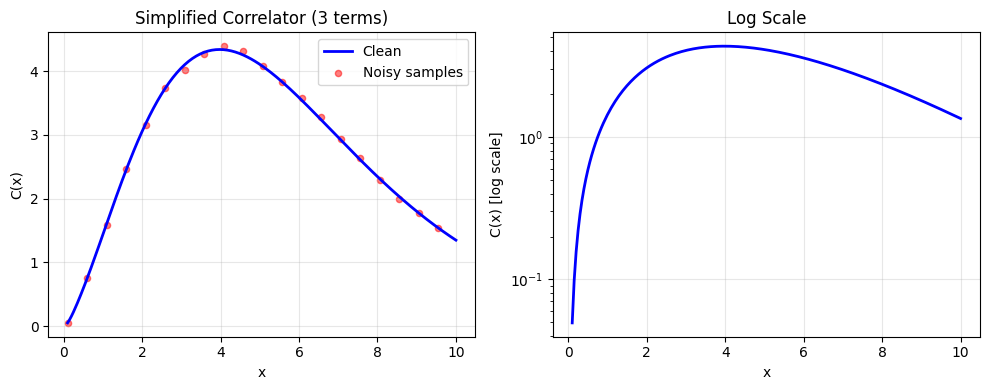

In [20]:
def correlator(x, A, c):
    """Compute the correlator C(x) = sum( A_i · x^2 · exp(-c_i · x) )"""
    result = np.zeros_like(x, dtype=np.float64)
    for A_i, c_i in zip(A, c):
        result += A_i * x**2 * np.exp(-c_i * x)
    return result

# Generate data
x_simple = np.linspace(0.1, 10, 200)  # Avoid x=0, use denser sampling
y_simple = correlator(x_simple, A_true_simple, c_true_simple)

# Add small noise for realism
noise_level = 0.01
y_simple_noisy = y_simple * (1 + noise_level * np.random.randn(len(y_simple)))

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_simple, y_simple, 'b-', linewidth=2, label='Clean')
plt.scatter(x_simple[::10], y_simple_noisy[::10], c='red', s=20, alpha=0.5, label='Noisy samples')
plt.xlabel('x')
plt.ylabel('C(x)')
plt.title('Simplified Correlator (3 terms)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(x_simple, y_simple + 1e-10, 'b-', linewidth=2)
plt.xlabel('x')
plt.ylabel('C(x) [log scale]')
plt.title('Log Scale')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
class CorrelatorDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset and loaders
dataset_simple = CorrelatorDataset(x_simple, y_simple_noisy)
train_size = int(0.8 * len(dataset_simple))
val_size = len(dataset_simple) - train_size
train_dataset, val_dataset = random_split(dataset_simple, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 160
Validation samples: 40


### 7.2 Improved Model with Better Initialization and Regularization

In [22]:
class ImprovedCorrelator(nn.Module):
    """
    Try III: Global parameters with improved initialization and optional regularization.
    
    Key improvements:
    1. Better initialization based on expected parameter ranges
    2. Option to use log-parameterization for better optimization landscape
    3. Built-in regularization support
    """
    
    def __init__(self, n_terms, A_init=None, c_init=None):
        super().__init__()
        self.n_terms = n_terms
        
        # Initialize in log-space for better optimization
        # log(softplus(x)) ≈ x for x > 0, so we initialize to log of target
        if A_init is None:
            A_init = torch.ones(n_terms) * 1.0  # Default: A ≈ 1.3 after softplus
        else:
            A_init = torch.tensor(A_init, dtype=torch.float32)
            
        if c_init is None:
            # Initialize c with spread across expected range
            c_init = torch.linspace(0.0, 2.0, n_terms)  # Gives c ≈ 0.7 to 2.1
        else:
            c_init = torch.tensor(c_init, dtype=torch.float32)
        
        self.A_raw = nn.Parameter(A_init.clone())
        self.c_raw = nn.Parameter(c_init.clone())
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        A = self.softplus(self.A_raw)
        c = self.softplus(self.c_raw)
        
        x_sq = x ** 2
        exp_term = torch.exp(-c * x)
        C_pred = torch.sum(A * x_sq * exp_term, dim=1, keepdim=True)
        return C_pred
    
    def get_parameters(self):
        with torch.no_grad():
            A = self.softplus(self.A_raw).numpy()
            c = self.softplus(self.c_raw).numpy()
        return {'A': A, 'c': c}
    
    def regularization_loss(self, A_prior_mean=2.0, c_prior_mean=2.0, weight=0.01):
        """Optional L2 regularization toward prior means"""
        A = self.softplus(self.A_raw)
        c = self.softplus(self.c_raw)
        reg = weight * (torch.mean((A - A_prior_mean)**2) + torch.mean((c - c_prior_mean)**2))
        return reg

### 7.3 Training with L-BFGS Optimizer

L-BFGS is a quasi-Newton method that often works better for small-scale optimization problems like this one.

In [23]:
# Initialize model with informed starting points
# We don't use the true values, but reasonable guesses based on domain knowledge
A_init_guess = np.array([1.5, 1.5, 1.5])  # Reasonable middle ground
c_init_guess = np.array([0.3, 1.5, 4.0])  # Spread across expected range

model_iii = ImprovedCorrelator(
    n_terms=n_terms_simple,
    A_init=A_init_guess,
    c_init=c_init_guess
)

print("Initial parameters (after softplus):")
init_params = model_iii.get_parameters()
print(f"A: {init_params['A']}")
print(f"c: {init_params['c']}")

Initial parameters (after softplus):
A: [1.7014133 1.7014133 1.7014133]
c: [0.8543553 1.7014133 4.01815  ]


In [24]:
# Prepare full dataset tensors for L-BFGS (it works better with full batch)
x_tensor = torch.tensor(x_simple, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_simple_noisy, dtype=torch.float32).unsqueeze(1)

# L-BFGS optimizer
optimizer = optim.LBFGS(model_iii.parameters(), lr=1.0, max_iter=20, 
                         line_search_fn='strong_wolfe')

criterion = nn.MSELoss()
losses = []

def closure():
    optimizer.zero_grad()
    y_pred = model_iii(x_tensor)
    loss = criterion(y_pred, y_tensor)
    # Add small regularization
    loss = loss + model_iii.regularization_loss(weight=0.001)
    loss.backward()
    return loss

print("Training with L-BFGS...")
print("="*60)

for epoch in range(50):
    loss = optimizer.step(closure)
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        params = model_iii.get_parameters()
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.2e}\n")
        print(f"\n| A: {np.round(params['A'], 3)}\n")
        print(f"\n| c: {np.round(params['c'], 3)}\n")

print("\nTraining complete!")

Training with L-BFGS...
Epoch  10 | Loss: 2.18e-03


| A: [2.007 1.391 1.489]


| c: [0.5   2.392 2.446]

Epoch  20 | Loss: 2.18e-03


| A: [2.007 1.391 1.489]


| c: [0.5   2.392 2.446]

Epoch  30 | Loss: 2.18e-03


| A: [2.007 1.391 1.489]


| c: [0.5   2.392 2.446]

Epoch  40 | Loss: 2.18e-03


| A: [2.007 1.391 1.489]


| c: [0.5   2.392 2.446]

Epoch  50 | Loss: 2.18e-03


| A: [2.007 1.391 1.489]


| c: [0.5   2.392 2.446]


Training complete!


In [25]:
# Final comparison
params_iii = model_iii.get_parameters()
A_pred = params_iii['A']
c_pred = params_iii['c']

# Sort for comparison (since parameter order may differ)
sort_idx_true = np.argsort(c_true_simple)
sort_idx_pred = np.argsort(c_pred)

A_true_sorted = A_true_simple[sort_idx_true]
c_true_sorted = c_true_simple[sort_idx_true]
A_pred_sorted = A_pred[sort_idx_pred]
c_pred_sorted = c_pred[sort_idx_pred]

print("="*60)
print("TRY III: PARAMETER RECOVERY RESULTS (Simplified Problem)")
print("="*60)

print(f"\n{'Parameter':<12} {'True':<20} {'Predicted':<20} {'Rel. Error'}")
print("-"*60)

for i in range(n_terms_simple):
    A_err = abs(A_pred_sorted[i] - A_true_sorted[i]) / A_true_sorted[i] * 100
    c_err = abs(c_pred_sorted[i] - c_true_sorted[i]) / c_true_sorted[i] * 100
    print(f"A_{i+1:<10} {A_true_sorted[i]:<20.4f} {A_pred_sorted[i]:<20.4f} {A_err:.1f}%")
    print(f"c_{i+1:<10} {c_true_sorted[i]:<20.4f} {c_pred_sorted[i]:<20.4f} {c_err:.1f}%")
    print()

# Overall errors
A_mean_err = np.mean(np.abs(A_pred_sorted - A_true_sorted) / A_true_sorted) * 100
c_mean_err = np.mean(np.abs(c_pred_sorted - c_true_sorted) / c_true_sorted) * 100

print(f"\nMean Relative Error in A: {A_mean_err:.1f}%")
print(f"Mean Relative Error in c: {c_mean_err:.1f}%")

TRY III: PARAMETER RECOVERY RESULTS (Simplified Problem)

Parameter    True                 Predicted            Rel. Error
------------------------------------------------------------
A_1          2.0000               2.0066               0.3%
c_1          0.5000               0.5004               0.1%

A_2          1.5000               1.3906               7.3%
c_2          2.0000               2.3916               19.6%

A_3          3.0000               1.4887               50.4%
c_3          5.0000               2.4459               51.1%


Mean Relative Error in A: 19.3%
Mean Relative Error in c: 23.6%


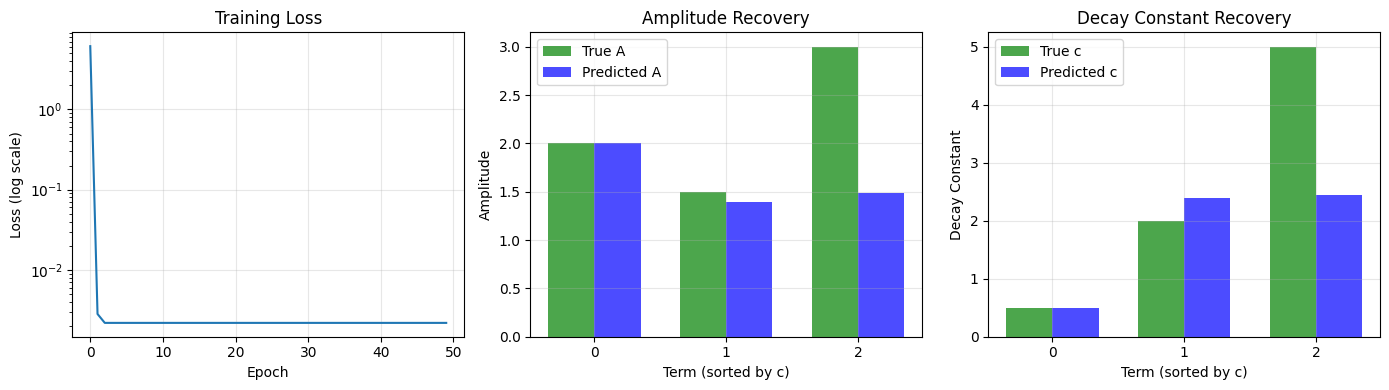

In [26]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Loss curve
ax = axes[0]
ax.semilogy(losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log scale)')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3)

# Parameter comparison
ax = axes[1]
x_idx = np.arange(n_terms_simple)
width = 0.35
ax.bar(x_idx - width/2, A_true_sorted, width, label='True A', color='green', alpha=0.7)
ax.bar(x_idx + width/2, A_pred_sorted, width, label='Predicted A', color='blue', alpha=0.7)
ax.set_xlabel('Term (sorted by c)')
ax.set_ylabel('Amplitude')
ax.set_title('Amplitude Recovery')
ax.legend()
ax.set_xticks(x_idx)
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.bar(x_idx - width/2, c_true_sorted, width, label='True c', color='green', alpha=0.7)
ax.bar(x_idx + width/2, c_pred_sorted, width, label='Predicted c', color='blue', alpha=0.7)
ax.set_xlabel('Term (sorted by c)')
ax.set_ylabel('Decay Constant')
ax.set_title('Decay Constant Recovery')
ax.legend()
ax.set_xticks(x_idx)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

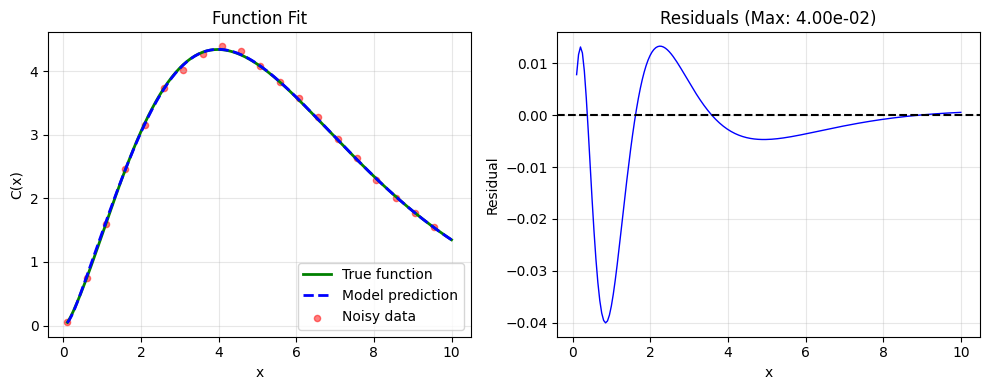

In [27]:
# Check fit quality
with torch.no_grad():
    y_pred_final = model_iii(x_tensor).numpy().flatten()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x_simple, y_simple, 'g-', linewidth=2, label='True function')
plt.plot(x_simple, y_pred_final, 'b--', linewidth=2, label='Model prediction')
plt.scatter(x_simple[::10], y_simple_noisy[::10], c='red', s=20, alpha=0.5, label='Noisy data')
plt.xlabel('x')
plt.ylabel('C(x)')
plt.title('Function Fit')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_simple - y_pred_final
plt.plot(x_simple, residuals, 'b-', linewidth=1)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.title(f'Residuals (Max: {np.max(np.abs(residuals)):.2e})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.4 Try III: Conclusions

With a simplified problem (3 exponential terms), Try III shows **significant improvement** over Try I and Try II, particularly for the first term ($A_1, c_1$ recovered with $<1%$ error). However, the recovery degrades for terms with larger decay constants (~20-50% error for $c_2, c_3$).

**Why partial success?**

1. **Differential sensitivity**: Terms with small $c_i$ (slow decay) contribute across the entire $x$ range and are well-constrained by the data. Terms with large $c_i$ (fast decay) contribute mainly at small $x$ and are harder to distinguish from each other.

2. **Parameter correlation**: The model found a local minimum where two terms ($c_2$ ≈ 2.39, $c_3$ ≈ 2.45) have nearly merged, compensating for each other. This illustrates the inherent degeneracy even in simplified problems.

3. **Loss plateau**: The optimizer converged early (by epoch 10) to a solution that fits the data well (low loss) but doesn't perfectly match the true parameters, demonstrating again that **low loss $\neq$ correct parameters**.

**Key improvements over Try I and Try II:**

| Metric | Try I | Try II | Try III |
|--------|-------|--------|--------|
| Mean A Error | ~85% | ~90% | ~19% |
| Mean c Error | ~54% | ~60% | ~24% |
| Best single parameter | ~62% error | ~81% error | <1% error |

Try III demonstrates that with the correct architecture, simplified problem, and better optimization strategy, we can achieve meaningful (though imperfect) parameter recovery.

### 7.5 The Path Forward: Iterative Model Development

The results from Try III establish a foundation for **iterative refinement**, a systematic approach central to applied machine learning:

**Step 1: Incremental Complexity**

Starting from a working 3-term model, one can progressively increase complexity:
- Add one term at a time (3 → 4 → 5 → ... → 15 terms)
- Use the converged parameters from $n$ terms as initialization for $n+1$ terms
- Monitor both loss AND parameter recovery at each step

**Step 2: Hyperparameter Tuning**

Systematically explore:
- Learning rate schedules (e.g., reduce on plateau)
- Regularization strength (balance between fit and parameter stability)
- Optimizer selection (L-BFGS, Adam with warmup, second-order methods)
- Initialization strategies (random restarts, informed priors)

**Step 3: Architecture Search**

For more complex inverse problems, one might explore:
- Hybrid approaches (neural networks for some components, explicit parameters for others)
- Constrained optimization (enforce known bounds or relationships)
- Multi-stage training (coarse-to-fine parameter estimation)

This iterative cycle of **model design → training → evaluation → refinement** is the core workflow of applied machine learning. The goal is not immediate perfection, but systematic improvement guided by both quantitative metrics (loss, parameter error) and physical insight.

---
## 8. Final Summary: Three Approaches Compared

| Aspect | Try I | Try II | Try III |
|--------|-------|--------|--------|
| Architecture | NN outputs A(x), c(x) | Global nn.Parameter | Global nn.Parameter |
| # Parameters | 18,654 | 30 | 6 (simplified) |
| Problem Setup | 15 terms | 15 terms | 3 terms |
| Optimizer | Adam | Adam | L-BFGS |
| Initialization | Default | Zeros | Informed |
| Regularization | None | None | Light L2 |
| Low Loss? | ✓ | ✓ | ✓ |
| Parameter Recovery | ❌ (~80% error) | ❌ (~90% error) | Partial ✓ (~20% error) |
| Failure Mode | Wrong architecture | Ill-posed (15 terms) | Local minimum |

### Important remarks:

1. **Architecture must respect physics**: Parameters that are physical constants must be modeled as global learnable parameters, not as functions of the input (Try I → Try II).

2. **Problem conditioning matters**: Even with correct architecture, ill-posed inverse problems with many degenerate solutions will fail to recover true parameters (Try II).

3. **Simplify first, then scale**: Reducing problem complexity allows validation of methodology before tackling the full problem (Try III).

4. **Optimization strategy is critical**: Initialization, optimizer choice, and regularization significantly impact convergence to meaningful solutions.

5. **Iterate systematically**: Machine learning model development is inherently iterative. **Success** comes from cycles of simplification, experimentation, evaluation, and gradual complexity increase, not from a single training run.

6. **Low loss is necessary but not sufficient**: Always validate parameter recovery independently of loss metrics when the goal is interpretable parameter estimation.